# Diamond Analysis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from functools import reduce
from pyspark.sql.functions import col

In [4]:
## py310
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression


In [5]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()


In [6]:
# You can also access the SparkContext from the SparkSession
sc = spark.sparkContext

In [7]:
# For example, let's create a simple RDD
rdd = sc.parallelize([1, 2, 3, 4, 5])

# Perform an action (e.g., collect the elements in the RDD)
print(rdd.collect())

[1, 2, 3, 4, 5]


In [8]:
type(rdd)

pyspark.rdd.RDD

In [9]:

# Sample data as a list of tuples
data = [
    ("Alice", 34),
    ("Bob", 45),
    ("Charlie", 29)
]

# Define column names
columns = ["Name", "Age"]

# Create DataFrame using the sample data and column names
spark_df = spark.createDataFrame(data, columns)

# Show the DataFrame content
spark_df.show()

+-------+---+
|   Name|Age|
+-------+---+
|  Alice| 34|
|    Bob| 45|
|Charlie| 29|
+-------+---+



In [10]:
# Read CSV file into DataFrame
spark_df = spark.read.csv("Data/diamonds.csv", header=True, inferSchema=True)

# Show the DataFrame content
spark_df.show()

+---+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|_c0|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+---+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|  1| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
|  2| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
|  3| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
|  4| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
|  5| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
|  6| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
|  7| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
|  8| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
|  9| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 10| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
| 11|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 12| 0.23|    Ideal|    J|    VS1

- _c0: is the index
- carat: 0.2--5.01
- cut: Fair, Good, Very Good, Premium, Ideal
- color: from J (worst) to D (best) 
- clarity: I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)
- x length in mm (0--10.74)
- y width in mm (0--58.9)
- z depth in mm (0--31.8)

In [11]:
spark_df.dtypes

[('_c0', 'int'),
 ('carat', 'double'),
 ('cut', 'string'),
 ('color', 'string'),
 ('clarity', 'string'),
 ('depth', 'double'),
 ('table', 'double'),
 ('price', 'int'),
 ('x', 'double'),
 ('y', 'double'),
 ('z', 'double')]

### 1. Find column names

In [12]:
spark_df.columns

['_c0',
 'carat',
 'cut',
 'color',
 'clarity',
 'depth',
 'table',
 'price',
 'x',
 'y',
 'z']

This classic dataset contains the prices and other attributes of almost 54,000 diamonds. There are 10 attributes included in the dataset including the target ie. price.

## Feature description:

price price in US dollars ($326--$18,823)This is the target column containing tags for the features. 

The 4 Cs of Diamonds:-

carat (0.2--5.01) The carat is the diamond’s physical weight measured in metric carats.  One carat equals 1/5 gram and is subdivided into 100 points. Carat weight is the most objective grade of the 4Cs. 

cut (Fair, Good, Very Good, Premium, Ideal) In determining the quality of the cut, the diamond grader evaluates the cutter’s skill in the fashioning of the diamond. The more precise the diamond is cut, the more captivating the diamond is to the eye.  

color, from J (worst) to D (best) The colour of gem-quality diamonds occurs in many hues. In the range from colourless to light yellow or light brown. Colourless diamonds are the rarest. Other natural colours (blue, red, pink for example) are known as "fancy,” and their colour grading is different than from white colorless diamonds.  

clarity (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)) Diamonds can have internal characteristics known as inclusions or external characteristics known as blemishes. Diamonds without inclusions or blemishes are rare; however, most characteristics can only be seen with magnification.  

### Dimensions

x length in mm (0--10.74)

y width in mm (0--58.9)

z depth in mm (0--31.8)

depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79) The depth of the diamond is its height (in millimetres) measured from the culet (bottom tip) to the table (flat, top surface).

table width of the top of the diamond relative to widest point (43--95)

A diamond's table refers to the flat facet of the diamond seen when the stone is face up. The main purpose of a diamond table is to refract entering light rays and allow reflected light rays from within the diamond to meet the observer’s eye. The ideal table cut diamond will give the diamond stunning fire and brilliance.

![Diamond](Data/diamond_image.png)

## DataSet Analysis 

### 2. Find data types of columns

In [13]:
spark_df.schema

StructType([StructField('_c0', IntegerType(), True), StructField('carat', DoubleType(), True), StructField('cut', StringType(), True), StructField('color', StringType(), True), StructField('clarity', StringType(), True), StructField('depth', DoubleType(), True), StructField('table', DoubleType(), True), StructField('price', IntegerType(), True), StructField('x', DoubleType(), True), StructField('y', DoubleType(), True), StructField('z', DoubleType(), True)])

In [14]:
spark_df.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



### Shape and Size of DF

In [15]:
# Get the number of rows
spark_df.count()

53940

In [16]:
# Get the number of columns
len(spark_df.columns)

11

### Shape (rows, columns)

In [17]:
(spark_df.count(), len(spark_df.columns))

(53940, 11)

### 4. Get some basic statistics (e.g., count, mean, min, max, etc.)

In [18]:
spark_df.describe().show()

+-------+------------------+------------------+---------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|               _c0|             carat|      cut|color|clarity|             depth|             table|            price|                 x|                 y|                 z|
+-------+------------------+------------------+---------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|             53940|             53940|    53940|53940|  53940|             53940|             53940|            53940|             53940|             53940|             53940|
|   mean|           26970.5|0.7979397478679852|     NULL| NULL|   NULL| 61.74940489432624| 57.45718390804603|3932.799721913237| 5.731157211716609| 5.734525954764462|3.5387337782723316|
| stddev|15571.281096942537|0.4740112444054196|     NULL| NULL|   NULL|1.43

### 5. Get summary statistics for all columns

In [19]:
spark_df.summary().show()

+-------+------------------+------------------+---------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|               _c0|             carat|      cut|color|clarity|             depth|             table|            price|                 x|                 y|                 z|
+-------+------------------+------------------+---------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|             53940|             53940|    53940|53940|  53940|             53940|             53940|            53940|             53940|             53940|             53940|
|   mean|           26970.5|0.7979397478679852|     NULL| NULL|   NULL| 61.74940489432624| 57.45718390804603|3932.799721913237| 5.731157211716609| 5.734525954764462|3.5387337782723316|
| stddev|15571.281096942537|0.4740112444054196|     NULL| NULL|   NULL|1.43

## Find Missing Values

In [20]:
### Count null values for each column
spark_df.select(
    *[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in spark_df.columns]
).show()

+---+-----+---+-----+-------+-----+-----+-----+---+---+---+
|_c0|carat|cut|color|clarity|depth|table|price|  x|  y|  z|
+---+-----+---+-----+-------+-----+-----+-----+---+---+---+
|  0|    0|  0|    0|      0|    0|    0|    0|  0|  0|  0|
+---+-----+---+-----+-------+-----+-----+-----+---+---+---+



In [21]:
# Count empty string values across all columns
empty_count = reduce(
    lambda a, b: a + b, 
    [F.sum((F.col(c) == "").cast("int")).alias(c) for c in spark_df.columns]
)

# Aggregate the total count of empty string values across all columns
total_empty_strings = spark_df.select(empty_count).first()[0]

total_empty_strings

## first column to index

In [22]:
spark_df.show(2)

+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|_c0|carat|    cut|color|clarity|depth|table|price|   x|   y|   z|
+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|  1| 0.23|  Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
|  2| 0.21|Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
+---+-----+-------+-----+-------+-----+-----+-----+----+----+----+
only showing top 2 rows



In [23]:
# Drop the 'name' column
spark_df = spark_df.drop("_c0")

# Reorder the columns to move 'c0_ col' to the first position
# Note: Spark DataFrame doesn't support direct index, but we can reorder the columns
columns = spark_df.columns

spark_df_no_index = spark_df.select(columns)

# Show the modified DataFrame
spark_df_no_index.show()

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 0.23|    Ideal|    J|    VS1| 62.8| 56.0|  340|3.93| 3.9|2.46|
| 0.22|  Premium|    F|  

In [24]:
spark_df.filter((spark_df['x'] == 0) | (spark_df['y'] == 0) | (spark_df['z'] == 0)).show()

# spark_df.where((spark_df['x'] == 0) | (spark_df['y'] == 0) | (spark_df['z'] == 0)).show()

+-----+---------+-----+-------+-----+-----+-----+----+----+---+
|carat|      cut|color|clarity|depth|table|price|   x|   y|  z|
+-----+---------+-----+-------+-----+-----+-----+----+----+---+
|  1.0|  Premium|    G|    SI2| 59.1| 59.0| 3142|6.55|6.48|0.0|
| 1.01|  Premium|    H|     I1| 58.1| 59.0| 3167|6.66| 6.6|0.0|
|  1.1|  Premium|    G|    SI2| 63.0| 59.0| 3696| 6.5|6.47|0.0|
| 1.01|  Premium|    F|    SI2| 59.2| 58.0| 3837| 6.5|6.47|0.0|
|  1.5|     Good|    G|     I1| 64.0| 61.0| 4731|7.15|7.04|0.0|
| 1.07|    Ideal|    F|    SI2| 61.6| 56.0| 4954| 0.0|6.62|0.0|
|  1.0|Very Good|    H|    VS2| 63.3| 53.0| 5139| 0.0| 0.0|0.0|
| 1.15|    Ideal|    G|    VS2| 59.2| 56.0| 5564|6.88|6.83|0.0|
| 1.14|     Fair|    G|    VS1| 57.5| 67.0| 6381| 0.0| 0.0|0.0|
| 2.18|  Premium|    H|    SI2| 59.4| 61.0|12631|8.49|8.45|0.0|
| 1.56|    Ideal|    G|    VS2| 62.2| 54.0|12800| 0.0| 0.0|0.0|
| 2.25|  Premium|    I|    SI1| 61.3| 58.0|15397|8.52|8.42|0.0|
|  1.2|  Premium|    D|   VVS1| 62.1| 59

In [25]:
spark_df.filter((spark_df['x'] == 0) | (spark_df['y'] == 0) | (spark_df['z'] == 0)).count()

20

Seems 20 rows have 0 values in at least 1 dimension

In [26]:
spark_df.select(
    F.sum((F.col('x') == 0).cast('int')).alias('x_zero_count'),
    F.sum((F.col('y') == 0).cast('int')).alias('y_zero_count'),
    F.sum((F.col('z') == 0).cast('int')).alias('z_zero_count')
).show()

+------------+------------+------------+
|x_zero_count|y_zero_count|z_zero_count|
+------------+------------+------------+
|           8|           7|          20|
+------------+------------+------------+



In [27]:
# Filter rows where 'x', 'y', or 'z' are 0
spark_df_cleaned = spark_df.filter((spark_df['x'] != 0) & (spark_df['y'] != 0) & (spark_df['z'] != 0))

# Show the cleaned DataFrame (optional)
spark_df_cleaned.show(2)

+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|carat|    cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|  Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
only showing top 2 rows



In [28]:
(spark_df.count(), len(spark_df.columns))

(53940, 10)

In [29]:
(spark_df_cleaned.count(), len(spark_df_cleaned.columns))

(53920, 10)

## Linear Regression

In [30]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Prepare the data for regression (Spark ML format)
assembler = VectorAssembler(inputCols=["price"], outputCol="features")
spark_df_cleaned = assembler.transform(spark_df_cleaned)

# Fit the regression model
lr = LinearRegression(featuresCol="features", labelCol="y")
model = lr.fit(spark_df_cleaned)

# Make predictions
predictions = model.transform(spark_df_cleaned)

# Show some predictions
predictions.select("price", "y", "prediction").show(5)

+-----+----+------------------+
|price|   y|        prediction|
+-----+----+------------------+
|  326|3.98|4.8402801654389105|
|  326|3.84|4.8402801654389105|
|  327|4.07|4.8405283231557785|
|  334|4.23| 4.842265427173853|
|  335|4.35|  4.84251358489072|
+-----+----+------------------+
only showing top 5 rows



## Plots

In [31]:
pandas_df = pd.read_csv("Data/diamonds.csv")
pandas_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [32]:
diamonds_df = pandas_df.drop(columns=['Unnamed: 0'])
diamonds_df.head(2)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31


In [33]:
diamonds_df.shape

(53940, 10)

In [34]:
diamonds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [35]:
diamonds_df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [36]:
#Dropping dimentionless diamonds
diamonds_df = diamonds_df.drop(diamonds_df[diamonds_df["x"]==0].index)
diamonds_df = diamonds_df.drop(diamonds_df[diamonds_df["y"]==0].index)
diamonds_df = diamonds_df.drop(diamonds_df[diamonds_df["z"]==0].index)
diamonds_df.shape

(53920, 10)

In [37]:
from sklearn.linear_model import LinearRegression

### Analyzing the Correlation Between Price and Y Dimension

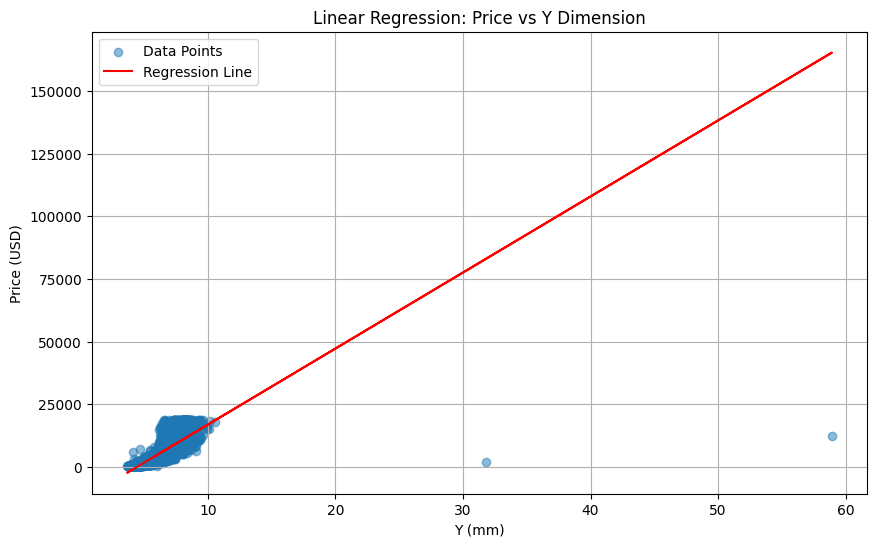

In [38]:
# Extract the relevant columns
x_values = diamonds_df['y']
y_values = diamonds_df['price']

# Clean data by removing rows with invalid or zero values in 'y'
cleaned_data = diamonds_df[(diamonds_df['y'] > 0) & (diamonds_df['price'] > 0)]

# Extract the cleaned x and y values
x_cleaned = cleaned_data['y'].values.reshape(-1, 1)
y_cleaned = cleaned_data['price'].values

# Fit a linear regression model
model = LinearRegression()
model.fit(x_cleaned, y_cleaned)

# Predict values for the regression line
y_predicted = model.predict(x_cleaned)

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_cleaned, y_cleaned, alpha=0.5, label="Data Points")
plt.plot(x_cleaned, y_predicted, color='red', label="Regression Line")
plt.title("Linear Regression: Price vs Y Dimension")
plt.xlabel("Y (mm)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

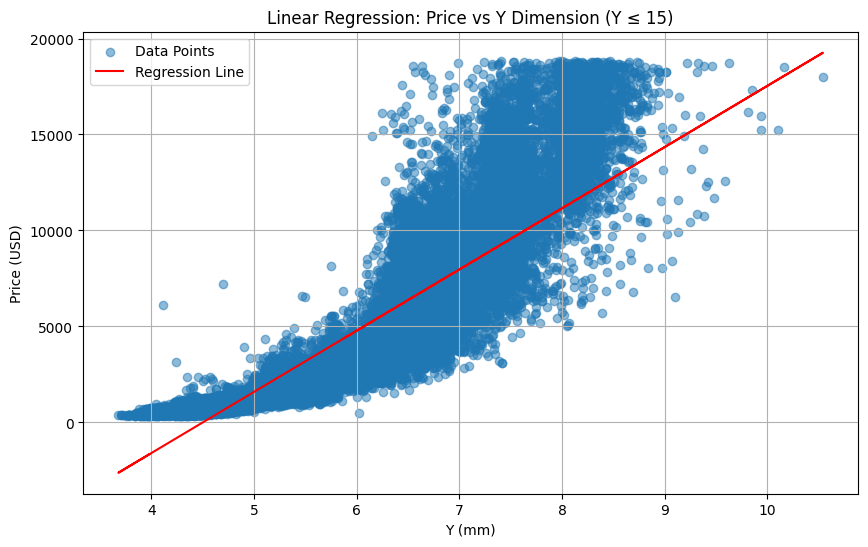

In [39]:
# Filter rows where y <= 15
filtered_data = diamonds_df[diamonds_df['y'] <= 15]

# Extract the relevant columns
x_filtered = filtered_data['y'].values.reshape(-1, 1)
y_filtered = filtered_data['price'].values

# Fit a linear regression model
model = LinearRegression()
model.fit(x_filtered, y_filtered)

# Predict values for the regression line
y_predicted = model.predict(x_filtered)

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_filtered, y_filtered, alpha=0.5, label="Data Points")
plt.plot(x_filtered, y_predicted, color='red', label="Regression Line")
plt.title("Linear Regression: Price vs Y Dimension (Y ≤ 15)")
plt.xlabel("Y (mm)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

lets reverse the axis 

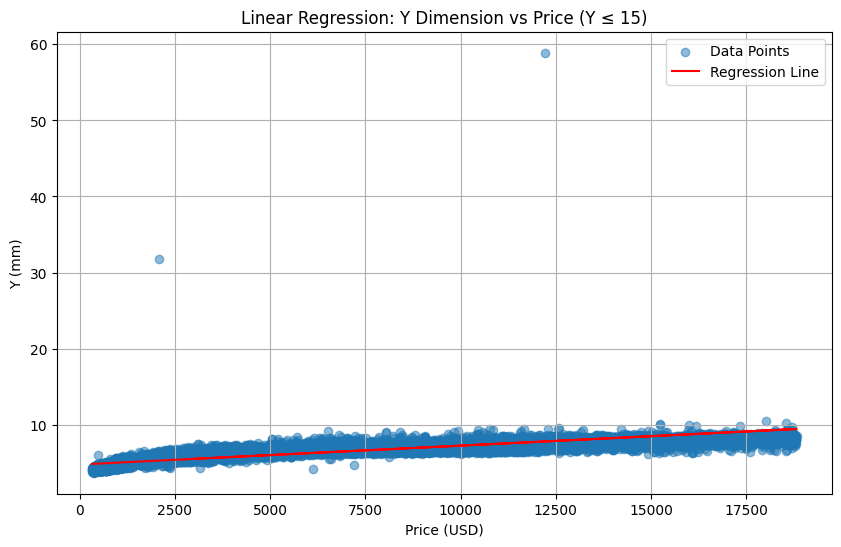

In [40]:
# Filter rows where y <= 15
filtered_data = diamonds_df

# Extract the relevant columns
x_filtered = filtered_data['price'].values.reshape(-1, 1)  # Price on x-axis
y_filtered = filtered_data['y'].values  # Y on y-axis

# Fit a linear regression model
model = LinearRegression()
model.fit(x_filtered, y_filtered)

# Predict values for the regression line
y_predicted = model.predict(x_filtered)

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_filtered, y_filtered, alpha=0.5, label="Data Points")
plt.plot(x_filtered, y_predicted, color='red', label="Regression Line")
plt.title("Linear Regression: Y Dimension vs Price (Y ≤ 15)")
plt.xlabel("Price (USD)")
plt.ylabel("Y (mm)")
plt.legend()
plt.grid(True)
plt.show()

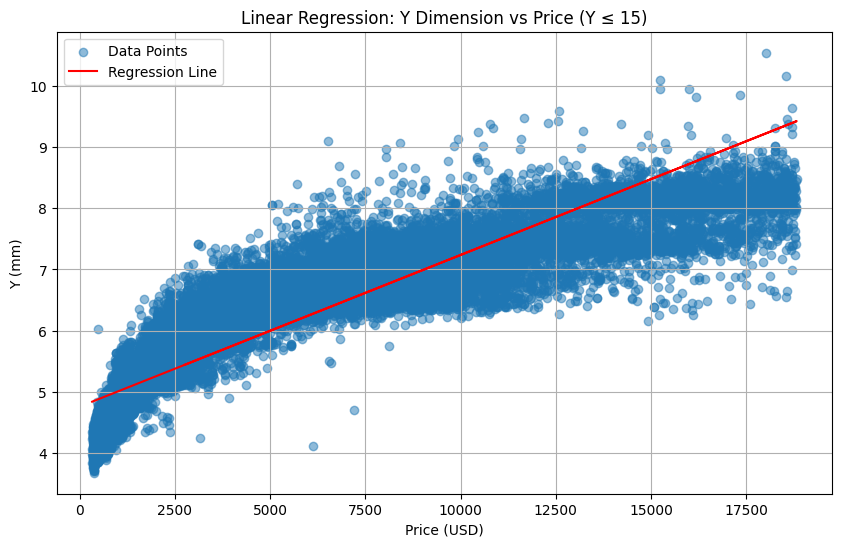

In [41]:
# Filter rows where y <= 15
filtered_data = diamonds_df[diamonds_df['y'] <= 15]

# Extract the relevant columns
x_filtered = filtered_data['price'].values.reshape(-1, 1)  # Price on x-axis
y_filtered = filtered_data['y'].values  # Y on y-axis

# Fit a linear regression model
model = LinearRegression()
model.fit(x_filtered, y_filtered)

# Predict values for the regression line
y_predicted = model.predict(x_filtered)

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_filtered, y_filtered, alpha=0.5, label="Data Points")
plt.plot(x_filtered, y_predicted, color='red', label="Regression Line")
plt.title("Linear Regression: Y Dimension vs Price (Y ≤ 15)")
plt.xlabel("Price (USD)")
plt.ylabel("Y (mm)")
plt.legend()
plt.grid(True)
plt.show()

#### Comments on the Graph: Price vs Y Dimension

#### 1. **Overview**
   - This scatter plot explores how the `y` dimension (width in mm) correlates with `price` (in USD).
   - The **x-axis** represents the `price` (USD), and the **y-axis** represents the `y` dimension of the diamonds.
   - The red line represents the **linear regression line**, showing the overall trend between these two variables.

#### 2. **Observations**
   - The data points exhibit a moderate spread, indicating variability in the `y` dimension across different price ranges.
   - The regression line suggests a **positive correlation**, implying that as the `price` increases, the `y` dimension tends to increase.

#### 3. **Correlation Insight**
   - The positive trend reflects that wider diamonds (in terms of the `y` dimension) are generally associated with higher prices.
   - However, the scatter of points around the regression line suggests that other factors, such as carat size, cut, and clarity, significantly influence price.

#### 4. **Summary**
   - Some outliers and null points were removed to better fit the regression line, y == 0 and y >= 15.
   - While the regression line shows an upward trend, the dispersion of points highlights that the `y` dimension alone is not the sole determinant of price.
   - Further exploration of other dimensions and characteristics of diamonds could provide a more comprehensive understanding of price dynamics.
   

### Analyzing the Correlation Between Price and X Dimension

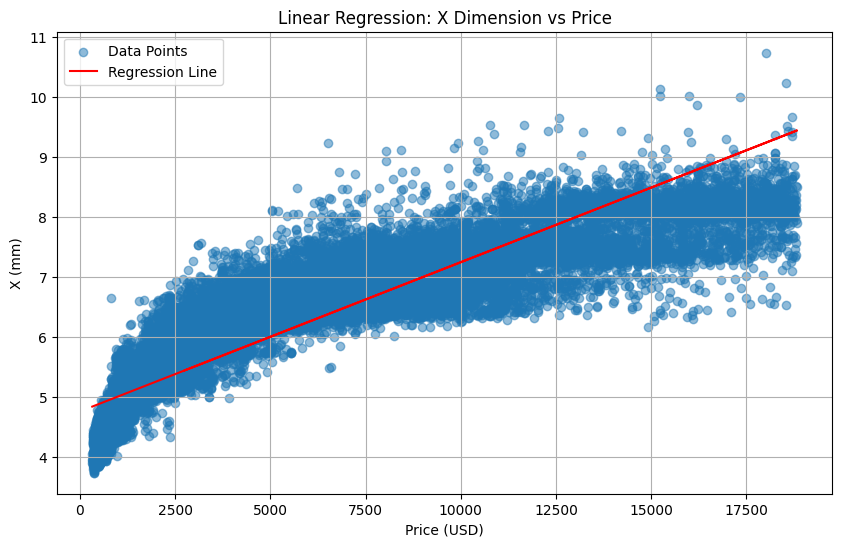

In [42]:
# Extract the relevant columns
x_values = diamonds_df['price'].values.reshape(-1, 1)  # Price on x-axis
y_values = diamonds_df['x'].values  # X dimension on y-axis

# Fit a linear regression model
model = LinearRegression()
model.fit(x_values, y_values)

# Predict values for the regression line
y_predicted = model.predict(x_values)

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.5, label="Data Points")
plt.plot(x_values, y_predicted, color='red', label="Regression Line")
plt.title("Linear Regression: X Dimension vs Price")
plt.xlabel("Price (USD)")
plt.ylabel("X (mm)")
plt.legend()
plt.grid(True)
plt.show()

#### Comments on the Graph: Price vs X Dimension

#### 1. **Overview**
   - This scatter plot examines how the `x` dimension (length in mm) correlates with `price` (in USD).
   - The **x-axis** represents the `price` (USD), while the **y-axis** represents the `x` dimension of the diamonds.
   - The red line represents the **linear regression line**, illustrating the average trend between these two variables.

#### 2. **Observations**
   - The data points show a moderate spread, indicating variability in the `x` dimension across different price ranges.
   - The regression line suggests a **positive correlation**, implying that as the `price` increases, the `x` dimension tends to increase.

#### 3. **Correlation Insight**
   - The positive trend indicates that larger diamonds (in terms of length) generally have higher prices.
   - However, the scatter of points around the regression line suggests that factors other than the `x` dimension significantly influence the price.

#### 4. **Summary**
   - There is a clear upward trend, but the variability of points highlights that other diamond characteristics (e.g., carat, cut, or clarity) also play a crucial role in determining price.
   - This plot provides insight into the relationship between price and the length (`x` dimension) of diamonds, but additional analysis of other dimensions or features may provide a more complete picture.


### Analyzing the Correlation Between the Price and the Z Dimension

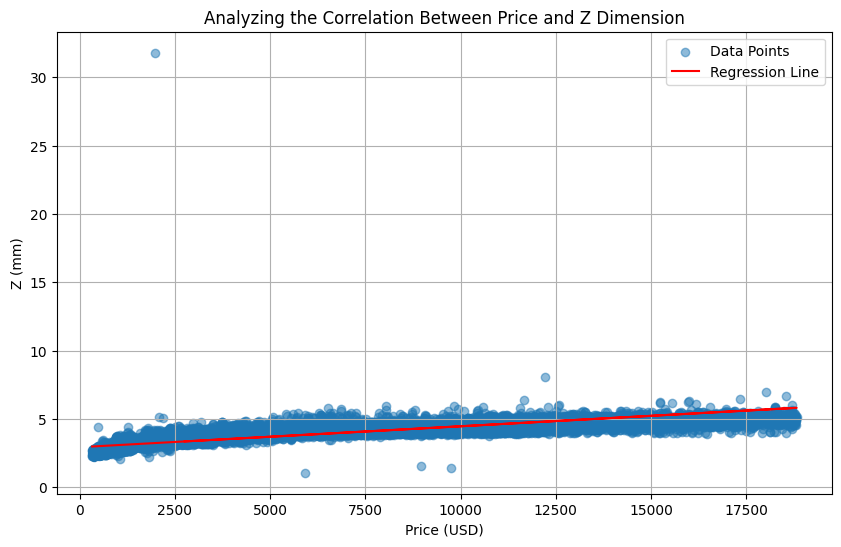

In [43]:
# Extract the relevant columns
x_values = diamonds_df['price'].values.reshape(-1, 1)  # Price on x-axis
y_values = diamonds_df['z'].values  # Z dimension on y-axis

# Fit a linear regression model
model = LinearRegression()
model.fit(x_values, y_values)

# Predict values for the regression line
y_predicted = model.predict(x_values)

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.5, label="Data Points")
plt.plot(x_values, y_predicted, color='red', label="Regression Line")
plt.title("Analyzing the Correlation Between Price and Z Dimension")
plt.xlabel("Price (USD)")
plt.ylabel("Z (mm)")
plt.legend()
plt.grid(True)
plt.show()

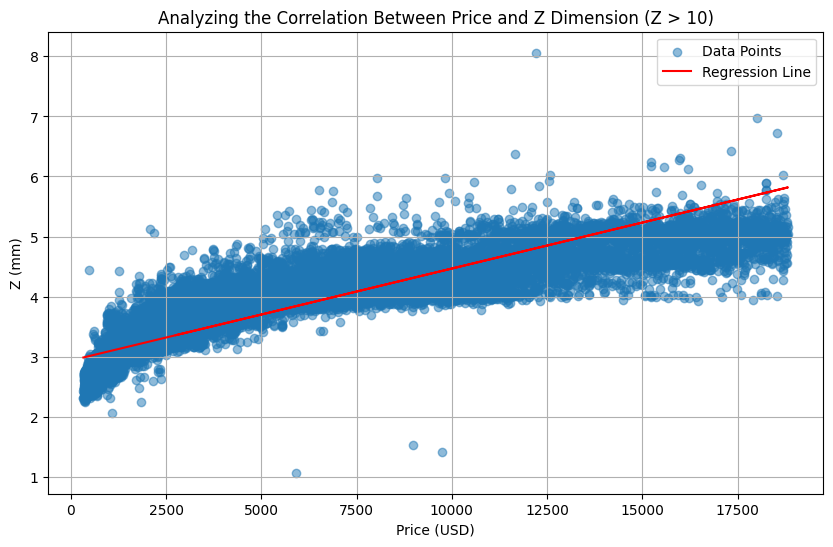

In [44]:
# Filter rows where z > 10
filtered_data = diamonds_df[diamonds_df['z'] < 10]

# Extract the relevant columns
x_values = filtered_data['price'].values.reshape(-1, 1)  # Price on x-axis
y_values = filtered_data['z'].values  # Z dimension on y-axis

# Fit a linear regression model
model = LinearRegression()
model.fit(x_values, y_values)

# Predict values for the regression line
y_predicted = model.predict(x_values)

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.5, label="Data Points")
plt.plot(x_values, y_predicted, color='red', label="Regression Line")
plt.title("Analyzing the Correlation Between Price and Z Dimension (Z > 10)")
plt.xlabel("Price (USD)")
plt.ylabel("Z (mm)")
plt.legend()
plt.grid(True)
plt.show()

#### Comments on the Graph: Price vs Z Dimension (Z < 10)

##### 1. **Overview**
   - This scatter plot analyzes diamonds where the `z` dimension (depth in mm) is less than 10.
   - The **x-axis** represents the `price` (in USD), and the **y-axis** represents the `z` dimension.
   - The red line is the **linear regression line**, showing the overall trend between `price` and `z`.

##### 2. **Observations**
   - The data points are more tightly clustered, indicating a narrow range of `z` dimensions in this group.
   - The regression line suggests a **weak positive correlation**, implying that as the `price` increases, the `z` dimension increases slightly.

##### 3. **Correlation Insight**
   - The weak correlation indicates that the `z` dimension has a limited direct impact on price in this range.
   - The dispersion of points around the regression line suggests other factors (like carat weight or clarity) significantly contribute to price variability.

##### 4. **Filter Impact**
   - By restricting the analysis to diamonds with `z < 10`, the focus is on smaller or more standard-depth diamonds, reducing outliers from unusually large dimensions.

##### 5. **Summary**
   - Some outliers and null points were removed to better fit the regression line, z == 0 and z > 10.
   - While there is a slight trend, the influence of the `z` dimension on price appears minimal in this filtered range.
   - Further analysis could explore how other variables (e.g., carat or cut) interact with price for this group.


### **Comparisson**

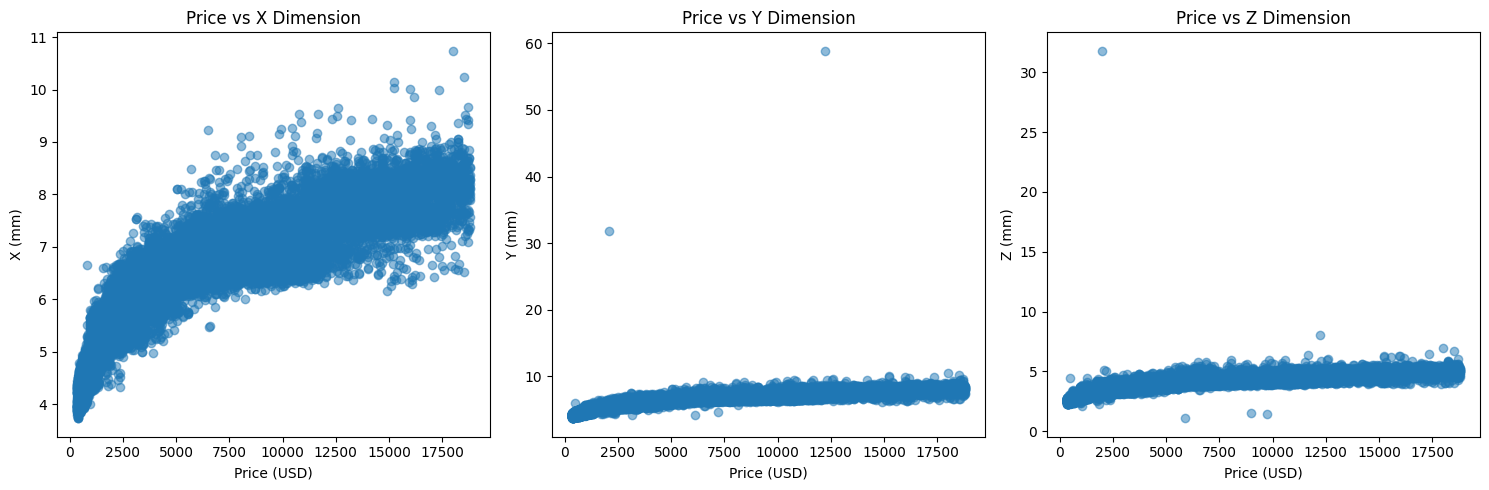

In [45]:
# Descriptive statistics for x, y, z, and price
descriptive_stats = diamonds_df[['x', 'y', 'z', 'price']].describe()

# Correlation coefficients between x, y, z, and price
correlation_matrix = diamonds_df[['x', 'y', 'z', 'price']].corr()

# Scatter plots for price vs x, y, z
plt.figure(figsize=(15, 5))

# Price vs X
plt.subplot(1, 3, 1)
plt.scatter(diamonds_df['price'], diamonds_df['x'], alpha=0.5)
plt.title("Price vs X Dimension")
plt.xlabel("Price (USD)")
plt.ylabel("X (mm)")

# Price vs Y
plt.subplot(1, 3, 2)
plt.scatter(diamonds_df['price'], diamonds_df['y'], alpha=0.5)
plt.title("Price vs Y Dimension")
plt.xlabel("Price (USD)")
plt.ylabel("Y (mm)")

# Price vs Z
plt.subplot(1, 3, 3)
plt.scatter(diamonds_df['price'], diamonds_df['z'], alpha=0.5)
plt.title("Price vs Z Dimension")
plt.xlabel("Price (USD)")
plt.ylabel("Z (mm)")

plt.tight_layout()
plt.show()

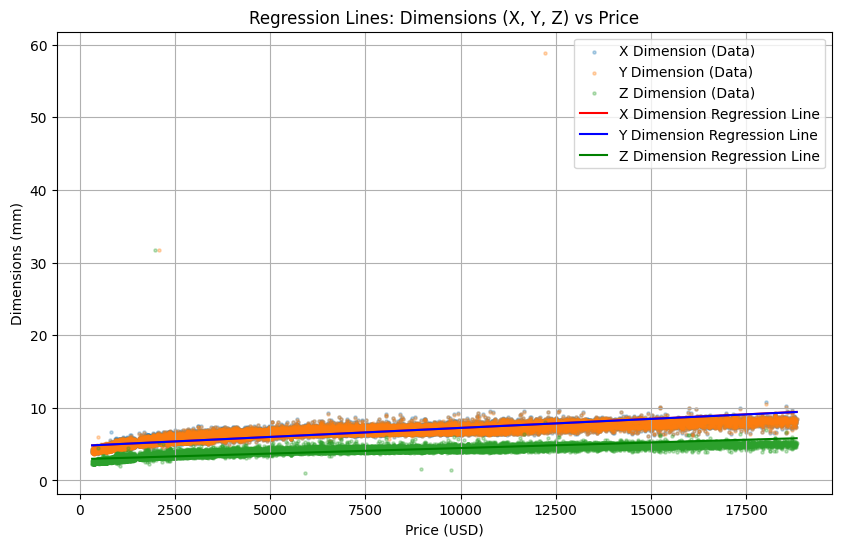

In [46]:
# Re-import necessary libraries and re-load data
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Extract dimensions and price
price = diamonds_df['price'].values.reshape(-1, 1)
x_dim = diamonds_df['x'].values
y_dim = diamonds_df['y'].values
z_dim = diamonds_df['z'].values

# Fit regression models for x, y, z
x_model = LinearRegression().fit(price, x_dim)
y_model = LinearRegression().fit(price, y_dim)
z_model = LinearRegression().fit(price, z_dim)

# Predict regression lines
price_range = pd.Series(price.ravel()).sort_values().values.reshape(-1, 1)  # Sort price for smoother lines
x_pred = x_model.predict(price_range)
y_pred = y_model.predict(price_range)
z_pred = z_model.predict(price_range)

# Plotting regression lines
plt.figure(figsize=(10, 6))
plt.scatter(price, x_dim, alpha=0.3, label="X Dimension (Data)", s=5)
plt.scatter(price, y_dim, alpha=0.3, label="Y Dimension (Data)", s=5)
plt.scatter(price, z_dim, alpha=0.3, label="Z Dimension (Data)", s=5)
plt.plot(price_range, x_pred, color='red', label="X Dimension Regression Line")
plt.plot(price_range, y_pred, color='blue', label="Y Dimension Regression Line")
plt.plot(price_range, z_pred, color='green', label="Z Dimension Regression Line")
plt.title("Regression Lines: Dimensions (X, Y, Z) vs Price")
plt.xlabel("Price (USD)")
plt.ylabel("Dimensions (mm)")
plt.legend()
plt.grid(True)
plt.show()

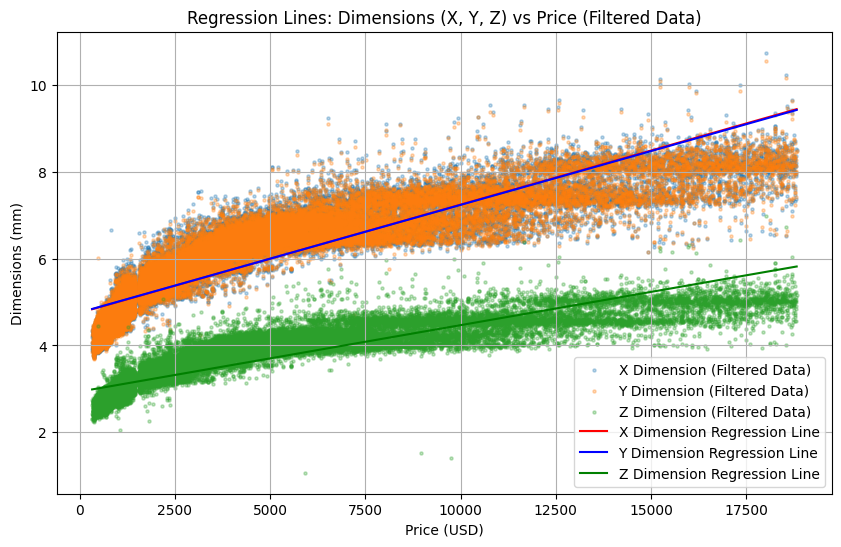

In [47]:
# Apply filters: z < 10 and positive values for dimensions
filtered_df = diamonds_df[(diamonds_df['x'] > 0) & 
                          (diamonds_df['y'] > 0) & 
                          (diamonds_df['z'] > 0) & 
                          (diamonds_df['z'] < 10) & 
                          (diamonds_df['y'] < 15)]

# Extract filtered dimensions and price
price_filtered = filtered_df['price'].values.reshape(-1, 1)
x_dim_filtered = filtered_df['x'].values
y_dim_filtered = filtered_df['y'].values
z_dim_filtered = filtered_df['z'].values

# Fit regression models for x, y, z with the filtered data
x_model_filtered = LinearRegression().fit(price_filtered, x_dim_filtered)
y_model_filtered = LinearRegression().fit(price_filtered, y_dim_filtered)
z_model_filtered = LinearRegression().fit(price_filtered, z_dim_filtered)

# Predict regression lines for filtered data
price_range_filtered = pd.Series(price_filtered.ravel()).sort_values().values.reshape(-1, 1)
x_pred_filtered = x_model_filtered.predict(price_range_filtered)
y_pred_filtered = y_model_filtered.predict(price_range_filtered)
z_pred_filtered = z_model_filtered.predict(price_range_filtered)

# Plotting regression lines with filtered data
plt.figure(figsize=(10, 6))
plt.scatter(price_filtered, x_dim_filtered, alpha=0.3, label="X Dimension (Filtered Data)", s=5)
plt.scatter(price_filtered, y_dim_filtered, alpha=0.3, label="Y Dimension (Filtered Data)", s=5)
plt.scatter(price_filtered, z_dim_filtered, alpha=0.3, label="Z Dimension (Filtered Data)", s=5)
plt.plot(price_range_filtered, x_pred_filtered, color='red', label="X Dimension Regression Line")
plt.plot(price_range_filtered, y_pred_filtered, color='blue', label="Y Dimension Regression Line")
plt.plot(price_range_filtered, z_pred_filtered, color='green', label="Z Dimension Regression Line")
plt.title("Regression Lines: Dimensions (X, Y, Z) vs Price (Filtered Data)")
plt.xlabel("Price (USD)")
plt.ylabel("Dimensions (mm)")
plt.legend()
plt.grid(True)
plt.show()

#### Comments on the Filtered Regression Plot: Price vs Dimensions (X, Y, Z)

##### 1. **Overview**
   - This plot visualizes the filtered data, where:
     - All dimensions (`x`, `y`, `z`) are positive.
     - The `z` dimension is restricted to values less than 10.
   - The scatter points represent the filtered data, and the regression lines (`x` in red, `y` in blue, `z` in green) illustrate trends between dimensions and price.

##### 2. **Observations**
   - **X Dimension (Red):**
     - The `x` dimension shows a strong positive correlation with price, evidenced by a steep regression line.
   - **Y Dimension (Blue):**
     - The `y` dimension exhibits a similar positive correlation with price, closely mirroring the trend observed for `x`.
   - **Z Dimension (Green):**
     - The `z` dimension has a flatter regression line, indicating a weaker relationship between depth (`z`) and price compared to `x` and `y`.

##### 3. **Correlation Between X and Y**
   - The regression lines for `x` and `y` dimensions are closely aligned, suggesting that these dimensions are highly correlated.
   - This correlation reflects the geometric relationship between the length (`x`) and width (`y`) of diamonds, which are naturally proportional in most cases.

##### 4. **Impact of Filters**
   - Restricting `z` to values less than 10 reduces the impact of extreme outliers, resulting in more concentrated data points for the `z` dimension.
   - Ensuring positive values for all dimensions eliminates anomalies, allowing for a more reliable analysis.

##### 5. **Summary**
   - Among the three dimensions, `x` and `y` have stronger and closely aligned correlations with price, likely due to their direct relationship with the visible size of diamonds.
   - The `z` dimension, representing depth, has a weaker influence on price and exhibits less variability.
   - Further analysis could explore additional variables, such as carat, cut, and clarity, to complement these findings.


### Analyzing the Correlation Between Price and Depth

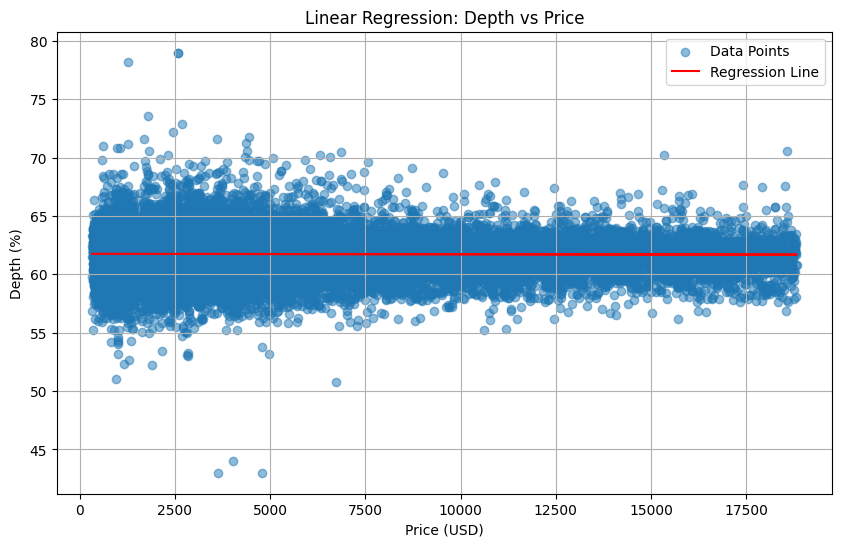

In [48]:
# Extract the relevant columns
x_values = diamonds_df['price'].values.reshape(-1, 1)  # Price on x-axis
y_values = diamonds_df['depth'].values  # Depth on y-axis

# Fit a linear regression model
model = LinearRegression()
model.fit(x_values, y_values)

# Predict values for the regression line
y_predicted = model.predict(x_values)

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.5, label="Data Points")
plt.plot(x_values, y_predicted, color='red', label="Regression Line")
plt.title("Linear Regression: Depth vs Price")
plt.xlabel("Price (USD)")
plt.ylabel("Depth (%)")
plt.legend()
plt.grid(True)
plt.show()

#### Comments on the Graph: Price vs Depth

1. Overview

- This scatter plot shows how the depth (as a percentage) of diamonds correlates with their price (USD).
- The x-axis represents the price (USD), and the y-axis represents the depth (%).
- The red line is the linear regression line, indicating the overall trend in the data.

2. Observations

- The points are densely concentrated around specific depth values, with relatively little variability in depth percentages for diamonds.
- The regression line is nearly flat, suggesting a very weak or negligible correlation between price and depth.

3. Correlation Insight

- The lack of a clear trend indicates that the depth percentage has minimal influence on the price of diamonds.
- Other factors, such as carat, clarity, and cut, likely play a more dominant role in determining price.

4. Summary

- The depth percentage appears to be a minor contributor to price variations.
- Further analysis could focus on other dimensions or characteristics to better understand the factors driving diamond pricing.

In [49]:
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


We can clearly spot outliers in these attributes. Next up, we will remove these data points.

In [50]:
diamonds_df.shape

(53920, 10)

In [51]:
#Dropping the outliers. 
filtered_dimaond_df = diamonds_df[(diamonds_df["depth"]<75)&(diamonds_df["depth"]>45)]
filtered_dimaond_df = filtered_dimaond_df[(filtered_dimaond_df["table"]<80)&(filtered_dimaond_df["table"]>40)]
filtered_dimaond_df = filtered_dimaond_df[(filtered_dimaond_df["x"]<30)]
filtered_dimaond_df = filtered_dimaond_df[(filtered_dimaond_df["y"]<30)]
filtered_dimaond_df = filtered_dimaond_df[(filtered_dimaond_df["z"]<30)&(filtered_dimaond_df["z"]>2)]
filtered_dimaond_df.shape

(53907, 10)

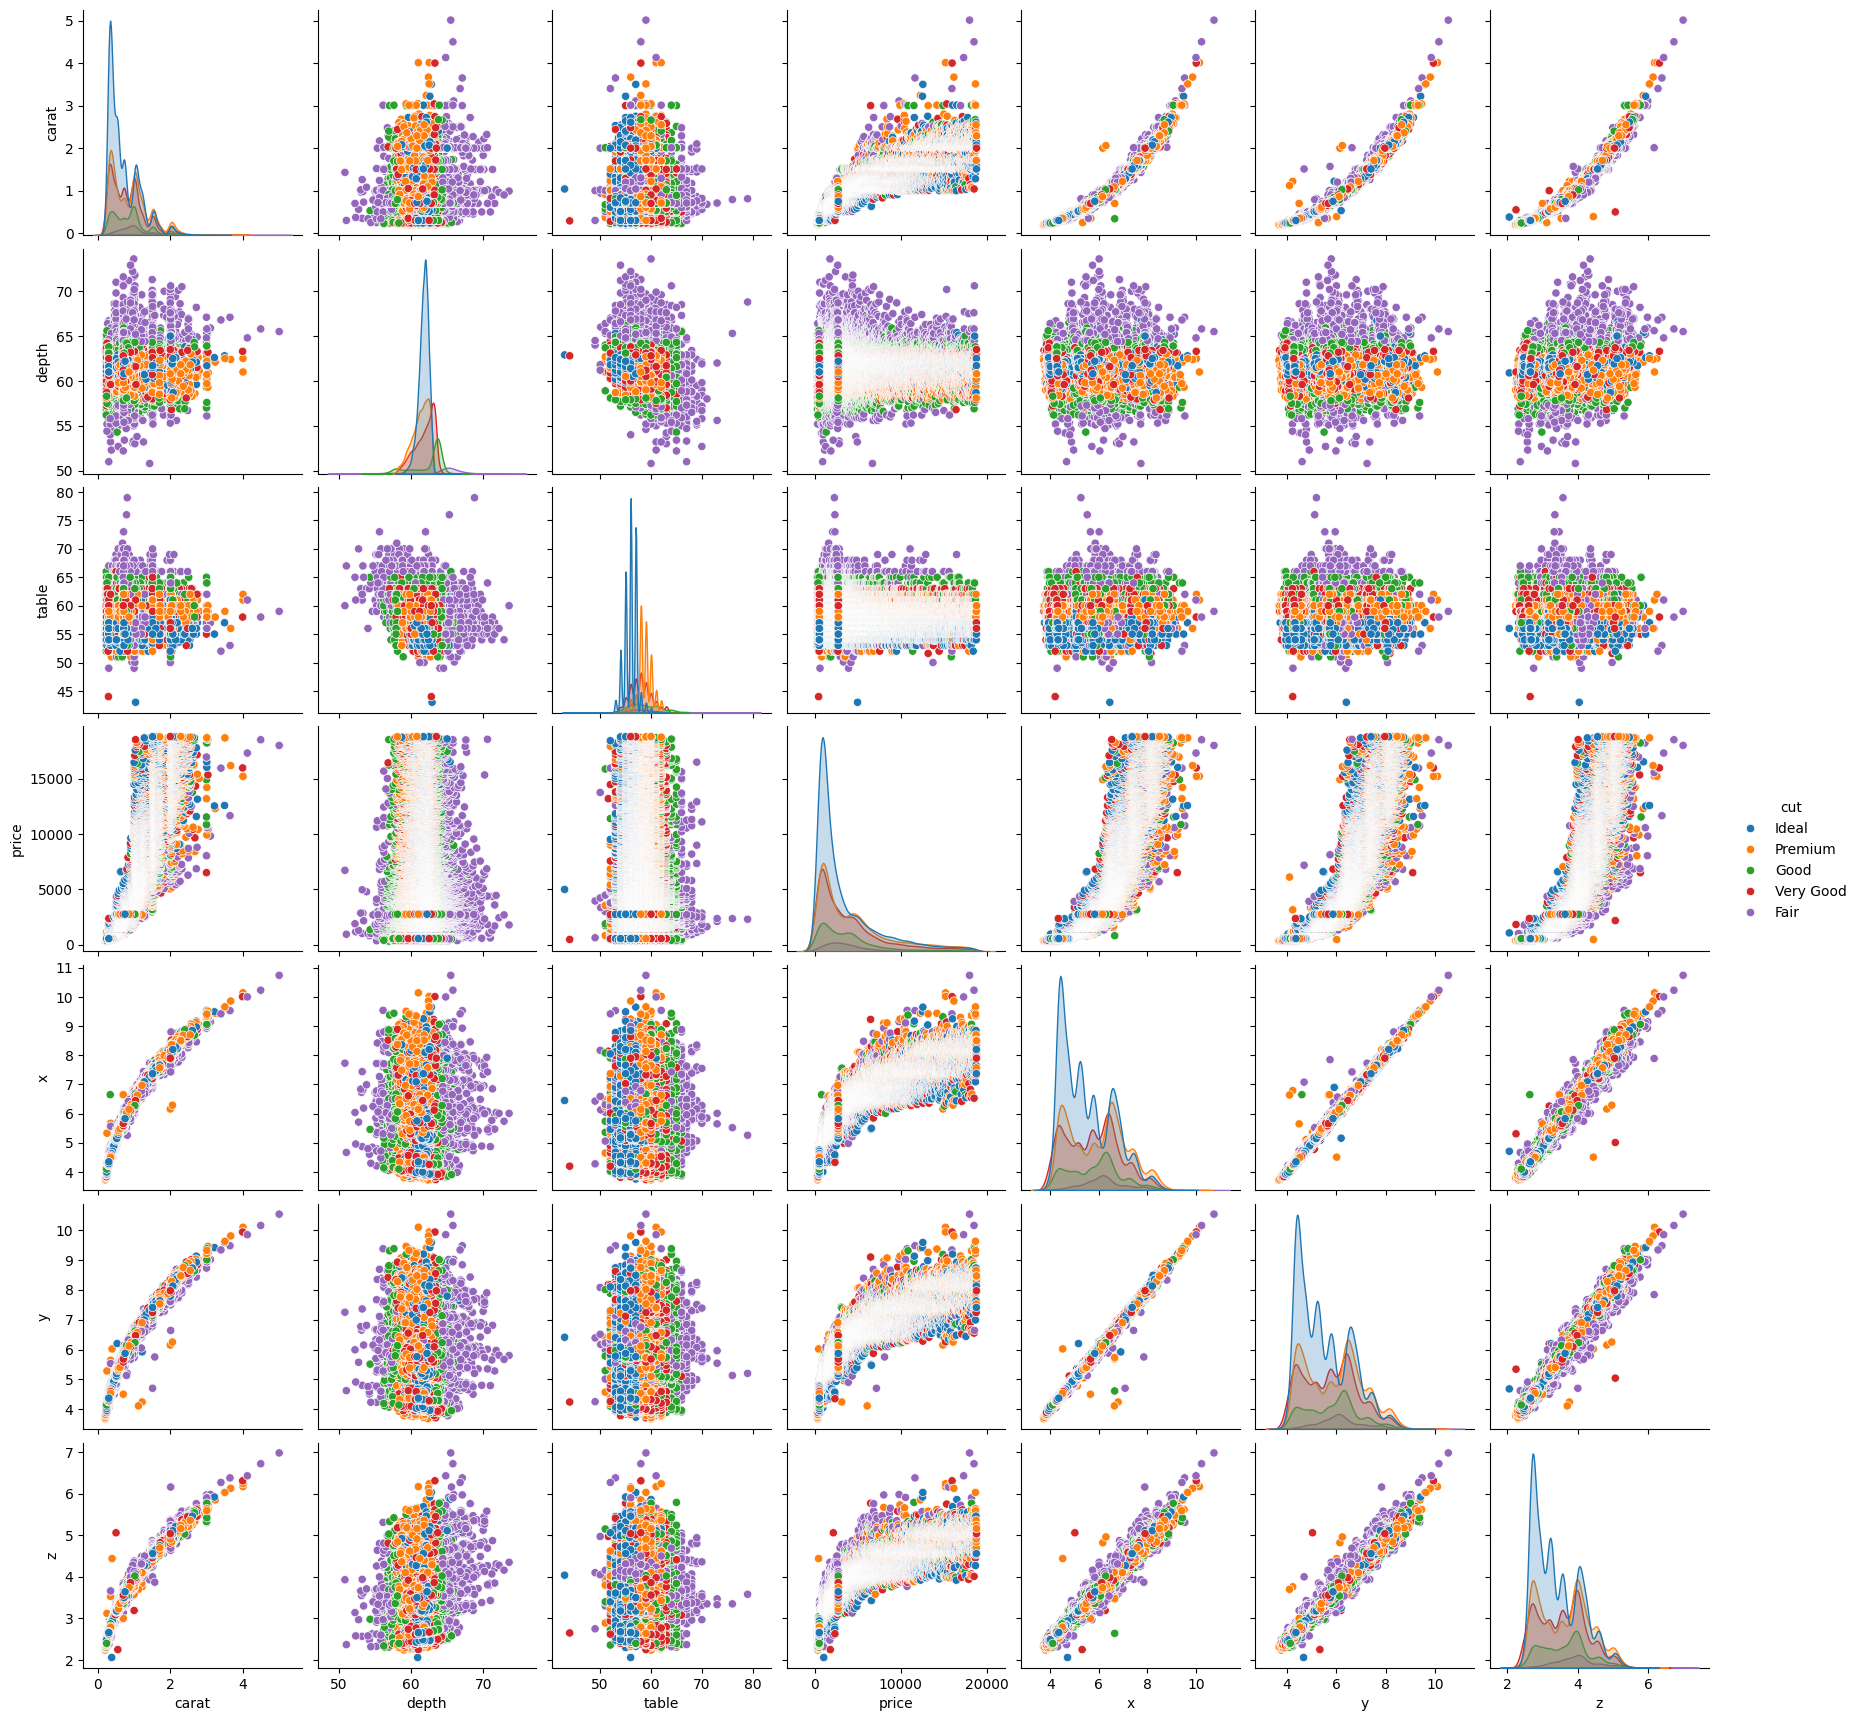

In [54]:
ax=sns.pairplot(filtered_dimaond_df, hue= "cut")

In [56]:
# Get list of categorical variables
s = (filtered_dimaond_df.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


### Calculating Correlation Matrix

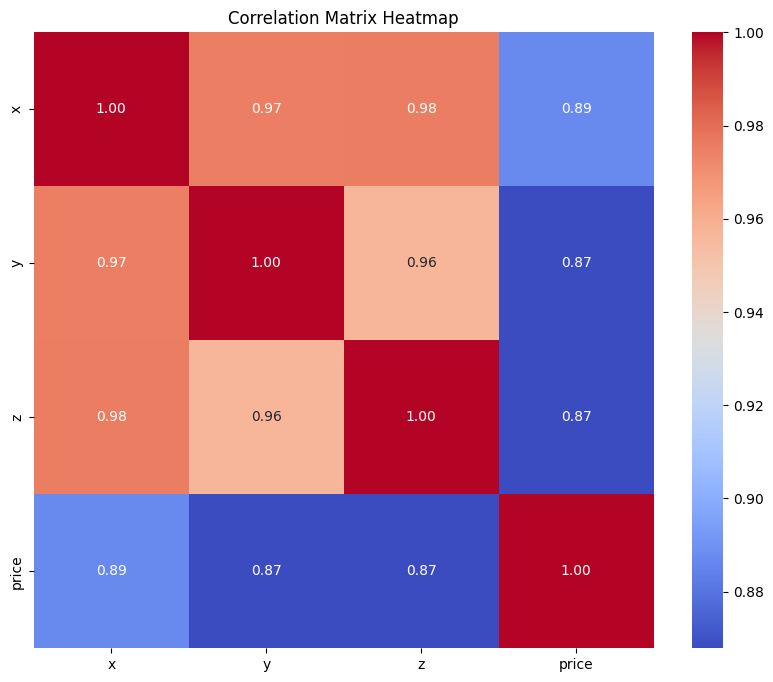

In [61]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [62]:
# Select only numeric columns for correlation calculation
numeric_columns = diamonds_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
          carat     depth     table     price         x         y         z
carat  1.000000  0.028259  0.181646  0.921592  0.977779  0.953991  0.961048
depth  0.028259  1.000000 -0.295733 -0.010729 -0.025017 -0.029069  0.095023
table  0.181646 -0.295733  1.000000  0.127245  0.196097  0.184493  0.152483
price  0.921592 -0.010729  0.127245  1.000000  0.887231  0.867864  0.868206
x      0.977779 -0.025017  0.196097  0.887231  1.000000  0.974918  0.975435
y      0.953991 -0.029069  0.184493  0.867864  0.974918  1.000000  0.956744
z      0.961048  0.095023  0.152483  0.868206  0.975435  0.956744  1.000000


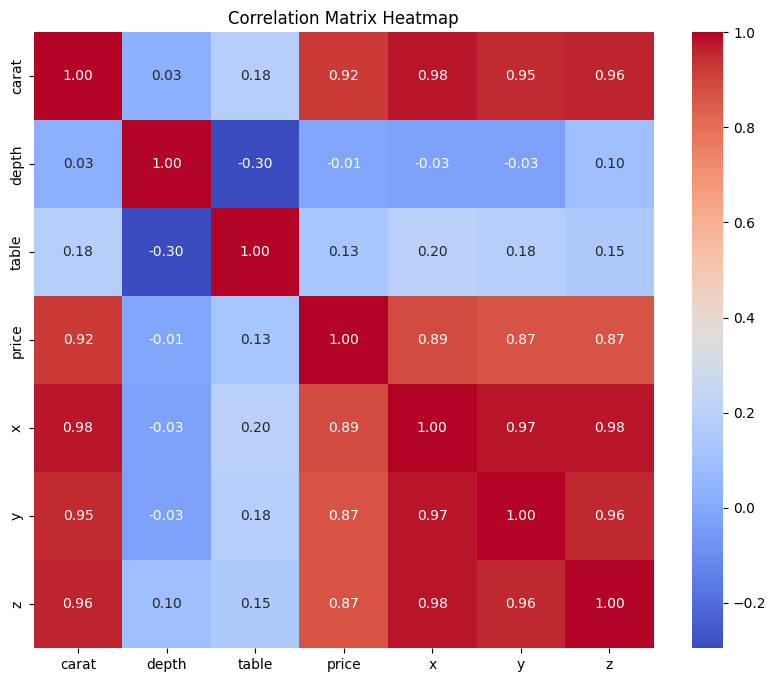

In [63]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

Points to notice:

"x", "y" and "z" show a high correlation to the target column.


"depth", "cut" and "table" show low correlation. We could consider dropping but let's keep it.

##### Comments on the Correlation Matrix

#### 1. **Strong Correlations**
   - **`x` and `y` Dimensions:**
     - A high positive correlation between `x` and `y` indicates that the length (`x`) and width (`y`) of diamonds are closely proportional, as expected from their geometric properties.
   - **`price` and `carat`:**
     - A strong positive correlation between `price` and `carat` highlights that carat size significantly impacts the price of diamonds.

#### 2. **Moderate Correlations**
   - **`price` with `x` and `y`:**
     - The moderate correlations between `price` and the `x` and `y` dimensions suggest that larger diamonds (in terms of length and width) tend to be more expensive.
   - **`z` with `x` and `y`:**
     - A moderate positive correlation between `z` (depth) and both `x` and `y` reflects that depth tends to increase proportionally with length and width.

#### 3. **Weak Correlations**
   - **`price` and `z`:**
     - The weak correlation between `price` and `z` suggests that depth plays a smaller role in determining the price of diamonds compared to other dimensions.
   - **`depth` with Other Dimensions:**
     - The low correlations between `depth` and `x`, `y`, or `z` indicate that depth percentage is not directly related to the absolute dimensions.

#### 4. **Insights**
   - The correlation matrix underscores the importance of carat size in diamond pricing, along with the role of length (`x`) and width (`y`).
   - Depth (`z`) and depth percentage are less influential, suggesting they are secondary factors in determining price.
   - The strong relationship between `x`, `y`, and `z` dimensions reflects the geometric consistency of diamonds.

#### 5. **Conclusion**
   - While carat size and dimensions (`x`, `y`) are key predictors of price, depth has a minimal impact.
   - Additional factors, such as clarity and cut, likely play significant roles and should be explored further to fully understand diamond pricing.


In [64]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid changing the original data
label_data = diamonds_df.copy()

# Identify columns with categorical data
object_cols = label_data.select_dtypes(include=['object']).columns

# Apply LabelEncoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])

# Display the first few rows of the encoded dataset
label_data.head()


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


<Axes: >

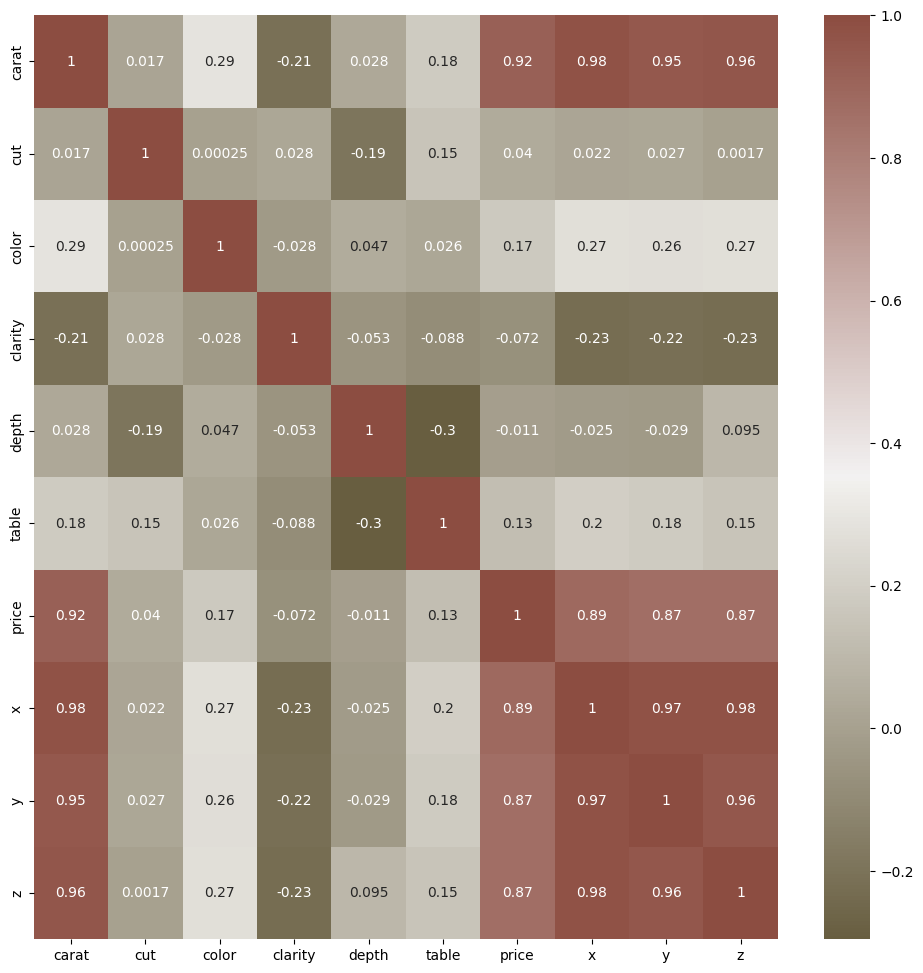

In [65]:
#correlation matrix
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= label_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

In [67]:
filtered_dimaond_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Carat vs Price

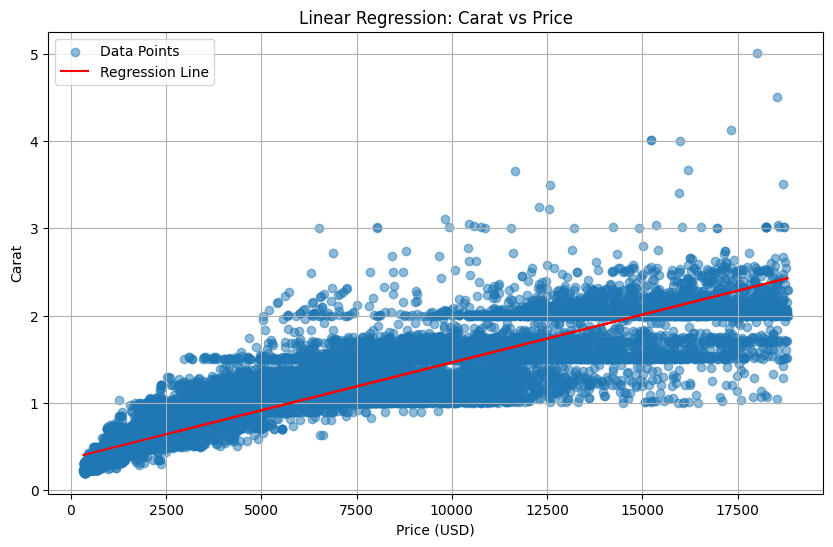

In [68]:
# Extract the relevant columns
x_values = diamonds_df['price'].values.reshape(-1, 1)  # Price on x-axis
y_values = diamonds_df['carat'].values  # Carat on y-axis

# Fit a linear regression model
model = LinearRegression()
model.fit(x_values, y_values)

# Predict values for the regression line
y_predicted = model.predict(x_values)

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.5, label="Data Points")
plt.plot(x_values, y_predicted, color='red', label="Regression Line")
plt.title("Linear Regression: Carat vs Price")
plt.xlabel("Price (USD)")
plt.ylabel("Carat")
plt.legend()
plt.grid(True)
plt.show()

## Model Building

Steps involved in Model Building:

- Setting up features and target

- Build a pipeline of standard scalar and model for five different regressors.

- Fit all the models on training data

- Get mean of cross-validation on the training set for all the models for negative root mean square error

- Pick the model with the best cross-validation score

- Fit the best model on the training set and get

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
# from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline